In [33]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline

In [30]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rows = []
for k in [1, 3, 5, 11, 50]:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])

    scores = cross_validate(
        pipe, X_train, y_train,
        cv=cv,
        scoring="accuracy",
        return_train_score=True
    )

    val = scores["test_score"]
    trn = scores["train_score"]

    rows.append({
        "k": k,
        "mean_val_acc": float(np.mean(val)),
        "var_val_acc":  float(np.var(val, ddof=1)),   # sample variance
        "mean_train_acc": float(np.mean(trn)),
        "var_train_acc":  float(np.var(trn, ddof=1)),
    })

table = pd.DataFrame(rows).sort_values("mean_val_acc", ascending=False)
print(table)
print()

table = pd.DataFrame(rows).sort_values("var_val_acc", ascending=False)
print(table)

    k  mean_val_acc  var_val_acc  mean_train_acc  var_train_acc
1   3      0.966667     0.000347        0.968750       0.000109
2   5      0.958333     0.000868        0.968750       0.000054
3  11      0.950000     0.002083        0.958333       0.000163
0   1      0.941667     0.000521        1.000000       0.000000
4  50      0.850000     0.005729        0.862500       0.000293

    k  mean_val_acc  var_val_acc  mean_train_acc  var_train_acc
4  50      0.850000     0.005729        0.862500       0.000293
3  11      0.950000     0.002083        0.958333       0.000163
2   5      0.958333     0.000868        0.968750       0.000054
0   1      0.941667     0.000521        1.000000       0.000000
1   3      0.966667     0.000347        0.968750       0.000109


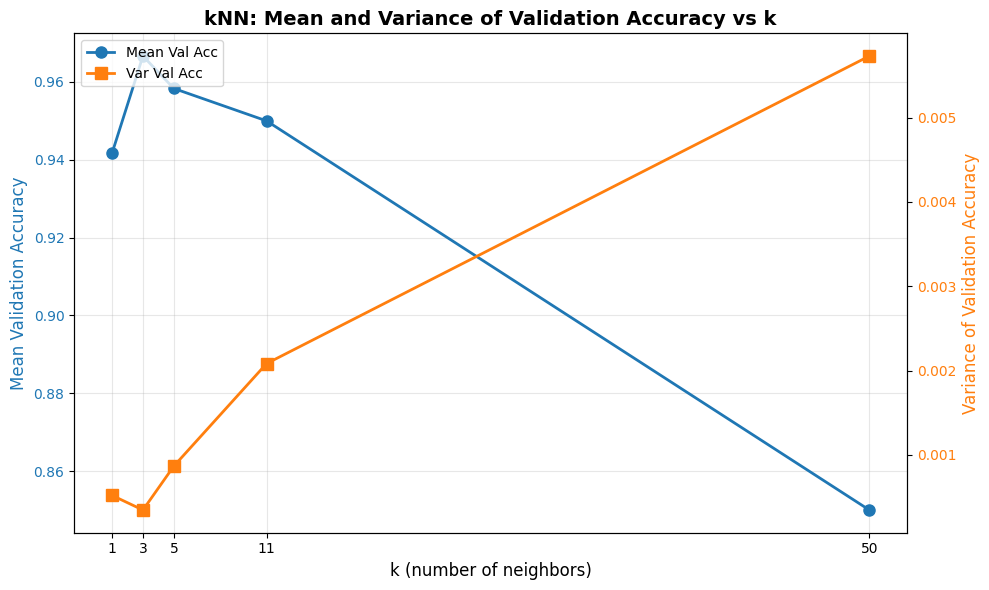

In [ ]:
knn_df = pd.DataFrame(rows).sort_values("k")

fig, ax1 = plt.subplots(figsize=(10, 6))

color1 = "tab:blue"
ax1.set_xlabel("k (number of neighbors)", fontsize=12)
ax1.set_ylabel("Mean Validation Accuracy", color=color1, fontsize=12)
line1 = ax1.plot(
    knn_df["k"],
    knn_df["mean_val_acc"],
    marker="o",
    color=color1,
    linewidth=2,
    markersize=8,
    label="Mean Val Acc",
)
ax1.tick_params(axis="y", labelcolor=color1)
ax1.set_xticks(knn_df["k"])
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
color2 = "tab:orange"
ax2.set_ylabel("Variance of Validation Accuracy", color=color2, fontsize=12)
line2 = ax2.plot(
    knn_df["k"],
    knn_df["var_val_acc"],
    marker="s",
    color=color2,
    linewidth=2,
    markersize=8,
    label="Var Val Acc",
)
ax2.tick_params(axis="y", labelcolor=color2)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left")

plt.title("kNN: Mean and Variance of Validation Accuracy vs k", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


In [38]:
svm_rows = []
kernel = "rbf"
for C in [0.1, 1.0, 10.0, 100.0]:
    for gamma in ["scale", "auto"]:
        pipe_steps = [("scaler", StandardScaler())]
        if gamma is None:
            pipe_steps.append(("svm", svm.SVC(kernel=kernel, C=C)))
        else:
            pipe_steps.append(("svm", svm.SVC(kernel=kernel, C=C, gamma=gamma)))

        pipe = Pipeline(pipe_steps)

        scores = cross_validate(
            pipe,
            X_train,
            y_train,
            cv=cv,
            scoring="accuracy",
            return_train_score=True,
        )

        val = scores["test_score"]
        trn = scores["train_score"]

        svm_rows.append(
            {
                "C": C,
                "gamma": gamma if gamma is not None else "-",
                "mean_val_acc": float(np.mean(val)),
                "var_val_acc": float(np.var(val, ddof=1)),
                "mean_train_acc": float(np.mean(trn)),
                "var_train_acc": float(np.var(trn, ddof=1)),
            }
        )

svm_table = pd.DataFrame(svm_rows).sort_values("mean_val_acc", ascending=False)
print("============ SVM CV ==============")
print(svm_table.head(10))
print()
print(svm_table.sort_values("var_val_acc", ascending=False).head(10))

============ SVM CV ==============
       C  gamma  mean_val_acc  var_val_acc  mean_train_acc  var_train_acc
2    1.0  scale      0.966667     0.000347        0.977083       0.000022
3    1.0   auto      0.966667     0.000347        0.977083       0.000022
4   10.0  scale      0.966667     0.000347        0.985417       0.000141
5   10.0   auto      0.966667     0.000347        0.985417       0.000141
6  100.0  scale      0.950000     0.002083        0.991667       0.000076
7  100.0   auto      0.950000     0.002083        0.991667       0.000076
0    0.1  scale      0.891667     0.002257        0.906250       0.000217
1    0.1   auto      0.891667     0.002257        0.906250       0.000217

       C  gamma  mean_val_acc  var_val_acc  mean_train_acc  var_train_acc
0    0.1  scale      0.891667     0.002257        0.906250       0.000217
1    0.1   auto      0.891667     0.002257        0.906250       0.000217
6  100.0  scale      0.950000     0.002083        0.991667       0.000076
7 

In [39]:
nb_rows = []
for var_smoothing in [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6]:
    pipe = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("gnb", GaussianNB(var_smoothing=var_smoothing)),
        ]
    )

    scores = cross_validate(
        pipe,
        X_train,
        y_train,
        cv=cv,
        scoring="accuracy",
        return_train_score=True,
    )

    val = scores["test_score"]
    trn = scores["train_score"]

    nb_rows.append(
        {
            "var_smoothing": var_smoothing,
            "mean_val_acc": float(np.mean(val)),
            "var_val_acc": float(np.var(val, ddof=1)),
            "mean_train_acc": float(np.mean(trn)),
            "var_train_acc": float(np.var(trn, ddof=1)),
        }
    )

nb_table = pd.DataFrame(nb_rows).sort_values("mean_val_acc", ascending=False)
print("============ GaussianNB CV ==============")
print(nb_table)
print()
print(nb_table.sort_values("var_val_acc", ascending=False))


============ GaussianNB CV ==============
   var_smoothing  mean_val_acc  var_val_acc  mean_train_acc  var_train_acc
0   1.000000e-12          0.95     0.000347        0.960417       0.000022
1   1.000000e-11          0.95     0.000347        0.960417       0.000022
2   1.000000e-10          0.95     0.000347        0.960417       0.000022
3   1.000000e-09          0.95     0.000347        0.960417       0.000022
4   1.000000e-08          0.95     0.000347        0.960417       0.000022
5   1.000000e-07          0.95     0.000347        0.960417       0.000022
6   1.000000e-06          0.95     0.000347        0.960417       0.000022

   var_smoothing  mean_val_acc  var_val_acc  mean_train_acc  var_train_acc
0   1.000000e-12          0.95     0.000347        0.960417       0.000022
1   1.000000e-11          0.95     0.000347        0.960417       0.000022
2   1.000000e-10          0.95     0.000347        0.960417       0.000022
3   1.000000e-09          0.95     0.000347        0.9604